# Assignment 4

**Assignment 4: Neural Networks**

**Goal**: ​Get familiar with neural networks by implementing them and applying them to image classification.

In this assignment we are going to learn about neural networks (NNs). The goal is to implement two neural networks: a fully-connected neural network, a convolutional neural network, and analyze their behavior.

The considered task is image classification. We consider a dataset of small natural images (see the additional file) with multiple classes. We aim at formulating a model (a neural network) and learning it using the negative log-likelihood function (i.e., the cross-entropy loss) as the objective function, and the stochastic gradient descent as the optimizer.

In this assignment, ​**the code must be implemented in PyTorch**.

## 1 Understanding the problem



The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In the second part, you are asked to implement the whole pipeline for a given dataset by yourself.

Please run the code below and spend a while on analyzing the images.

If any code line is unclear to you, please read on that in numpy, scipy, matplotlib and PyTorch docs.

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
import scipy

EPS = 1.0e-7


In [63]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# mount drive: WE NEED IT FOR SAVING IMAGES!
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
results_dir = "/content/gdrive/My_Drive/Colab Notebooks/TEACHING/"

In [ ]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

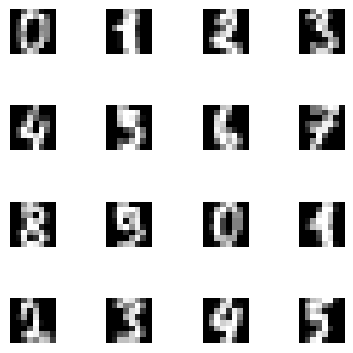

In [ ]:
# PLEASE DO NOT REMOVE
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

In [ ]:
# arr1 = np.ones(10)
# arr2 = np.reshape(arr1, (5,2))
# print(arr1, arr2)
# digits.data[5]
# x = digits.data[:16]
# for i in range(4):
#     for j in range(4):
#         img = np.reshape(x[4 * i + j], (8, 8))
#         print(4 * i + j)
#         print(i)
#         print(j)
#         print(img)
x = torch.zeros(3,6)
y = torch.tensor([[1,1,1,1], [2,2,2,2]])
y.shape

torch.Size([2, 4])

## 2 Neural Networks for Digits (4pt)

In this assignment, you are asked to implement a neural network (NN) classifier. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [ ]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).


# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        # print("Input tensor shape:", x.shape)
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [ ]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
# =========
# Implement a neural network (NN) classifier.
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # Pass an image through the neural network and get an output
        h = self.classnet(x)
        # Pass the output through the softmax function to get the probabilities
        # for each class
        probs = F.softmax(h, dim = 1)
        # Choose the class with the highest probability (returns a value, index Tuple)
        # Calulates the class with the highest probability across the 2nd dimension (dim=1)
        max_val, y_pred = torch.max(probs, dim = 1)
        # Return the index of the class with the highest probability
        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        # Pass an image through the neural network and get an output
        h = self.classnet(x)
        # Pass the output through the log_softmax function to get log probabilities
        # for each class
        log_probs = F.log_softmax(h, dim = 1)
        # compute the loss based on the negative log-likelihood.
        loss = self.nll(log_probs, y)
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

**Question 1 (0-0.5pt):** What is the objective function for a classification task? In other words, what is nn.NLLLoss in the code above? Pelase write it in mathematical terms.

**Answer:** The objective function is the negative log likelihood:

\begin{align*}
-∑logp(y_i|x_i,\theta)
\end{align*}



**Question 2 (0-0.5pt):** In the code above, it is said to use the logarithm of the softmax as the final activation function. Is it correct to use the log-softmax instead of the softmax for making predictions (i.e., picking the most probable label).

**Answer:** No, because the values obtained from the log-softmax function can't be directly interpreted as probabilities where the values of the softmax can. This way it is possible to actually choose the class with the highest probability.

### 2.2 Evaluation

In [ ]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

### 2.3 Training procedure

In [ ]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [ ]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
example = train_data[1][0]
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
print(f"Feature example shape: {example.shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Feature example shape: (64,)
Label example: 1


In [ ]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1, 8, 8))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")



How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


#### Initialize hyperparameters

In [ ]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

#### Running experiments

In the code below, you are supposed to implement architectures for MLP and CNN. For properly implementing these architectures, you can get 0.5pt for each of them.


-> START classifier_mlp
Epoch: 0, val nll=0.626473012651716, val ce=0.10285714285714286
Epoch: 10, val nll=0.0993191637311663, val ce=0.04285714285714286
Epoch: 20, val nll=0.10896362372807095, val ce=0.03142857142857143
Epoch: 30, val nll=0.09897192290851048, val ce=0.03142857142857143
-> FINAL PERFORMANCE: nll=0.2601726412506445, ce=0.07606263982102908


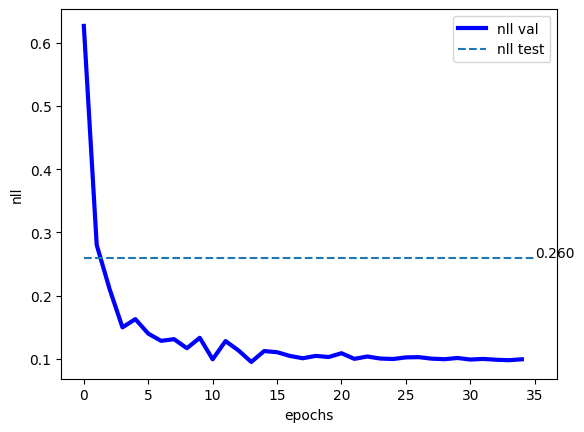

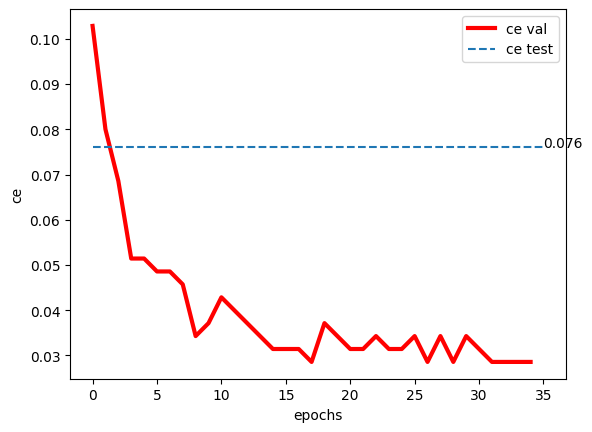


-> START classifier_cnn
Epoch: 0, val nll=0.7367273766653878, val ce=0.09428571428571429
Epoch: 10, val nll=0.09117988858904158, val ce=0.014285714285714285
Epoch: 20, val nll=0.06530804395675659, val ce=0.014285714285714285
Epoch: 30, val nll=0.052321548972811015, val ce=0.011428571428571429
Epoch: 40, val nll=0.048248993839536396, val ce=0.011428571428571429
Epoch: 50, val nll=0.04586230363164629, val ce=0.011428571428571429
Epoch: 60, val nll=0.04275275843484061, val ce=0.011428571428571429
Epoch: 70, val nll=0.04275316340582711, val ce=0.011428571428571429
Epoch: 80, val nll=0.040801363927977424, val ce=0.011428571428571429
Epoch: 90, val nll=0.0406219373856272, val ce=0.011428571428571429
Epoch: 100, val nll=0.039933488837310245, val ce=0.011428571428571429
-> FINAL PERFORMANCE: nll=0.18797429576016111, ce=0.0447427293064877


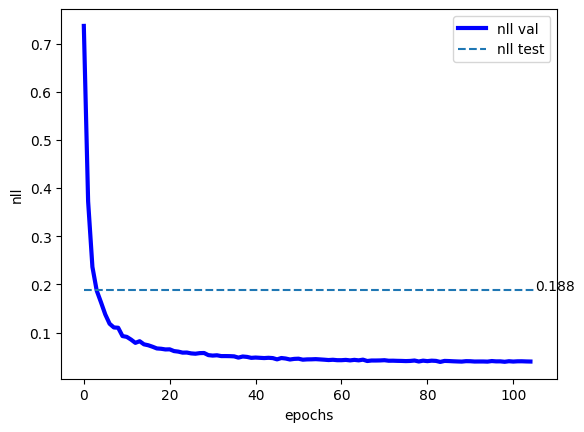

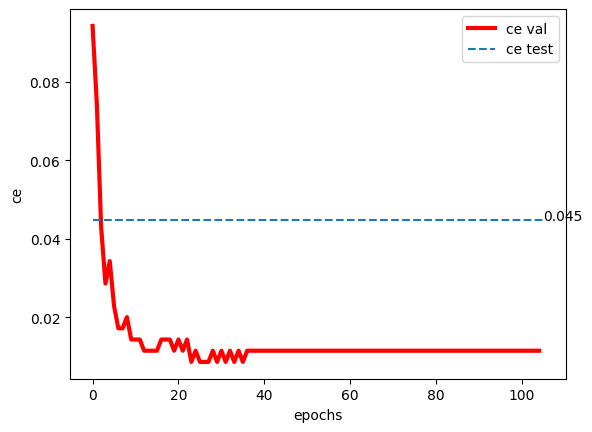

In [ ]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ["classifier_mlp", "classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    result_dir = os.path.join(results_dir, "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "./"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

    # MLP
    if name[0:14] == "classifier_mlp":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
            nn.Linear(D, M),  # Input layer
            nn.ReLU(),        # Activation function
            nn.Linear(M, M),  # Hidden layer
            nn.ReLU(),        # Activation function
            nn.Linear(M, M),  # Hidden layer
            nn.ReLU(),        # Activation function
            nn.Linear(M, K),  # Output layer
            nn.LogSoftmax(dim = 1)  # LogSoftmax activation for output
        )
        #
        # You are asked here to propose your own architecture
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------


    # CNN
    elif name[0:14] == "classifier_cnn":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
            Reshape(size = (1, 8, 8)),  # Reshape input to image dimensions
            nn.Conv2d(1, num_kernels, kernel_size = 3, padding = 1),  # Convolutional layer
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size = 2, stride = 2),  # Max pooling layer
            Flatten(),  # Flatten the output of convolutional layers
            nn.Linear(num_kernels * 4 * 4, M),  # Linear layer
            nn.ReLU(),  # Activation function
            nn.Linear(M, K),  # Output layer
            nn.LogSoftmax(dim = 1)  # LogSoftmax activation for output layer
        )
        #
        # You are asked here to propose your own architecture
        # NOTE: Plese note that the images are represented as vectors, thus, you must
        # use Reshape(size) as the first layer, and Flatten() after all convolutional
        # layers and before linear layers.
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------


    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )

## 2.5 Analysis

**Question 3 (0-0.5pt)**: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

**Answer**: While MLP starts of with a lower loss value, CNN shows a faster reduction, ultimately achieving a lower final loss overtaking MLP in performance. This indicates that MLP is better at converging to a minimal loss function. The comparison shows that CNN has the ability to discern between more complex patterns than ML and highlights it effectiveness in learning insightful features from the data. This ultimately leads to less classification errors (0.044) compared to MLP (0.076).

Classifier NLL

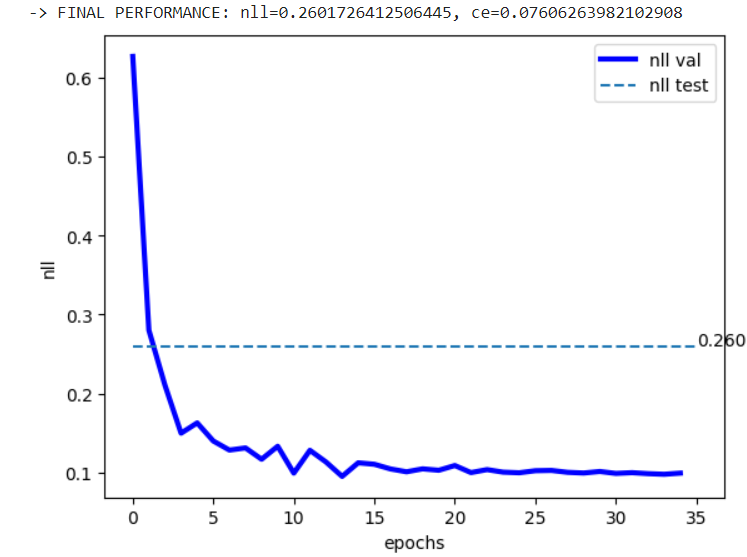

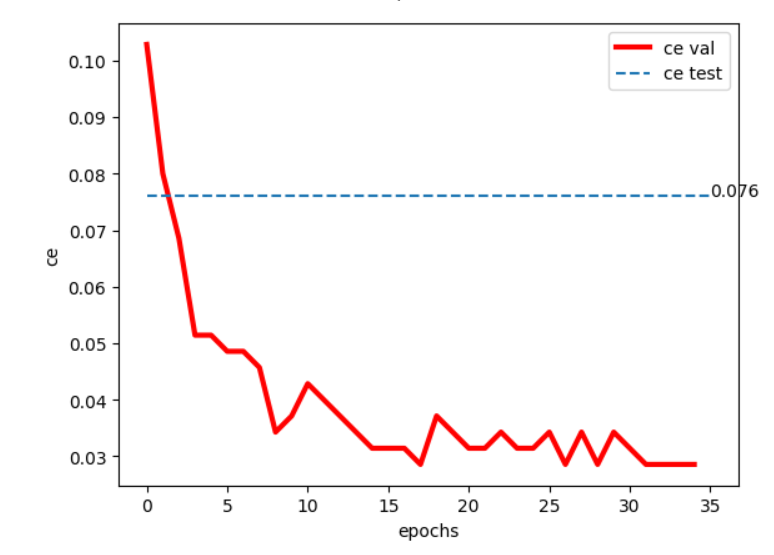


Classifier CNN

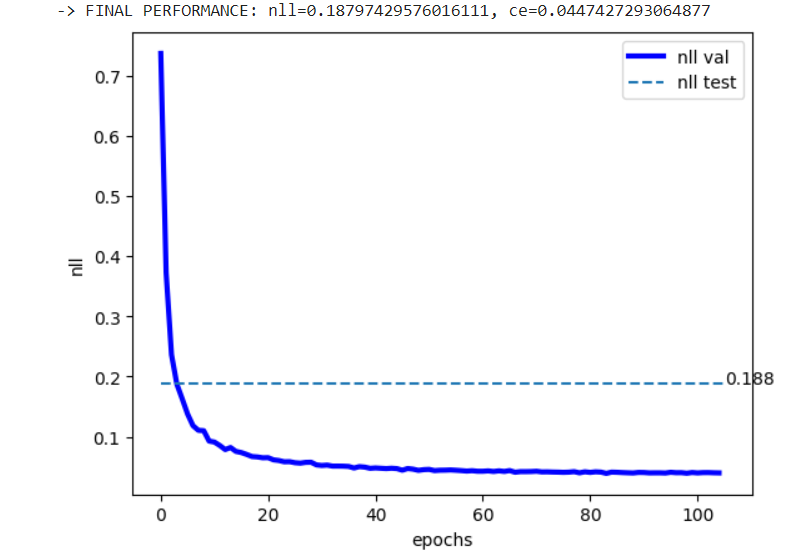

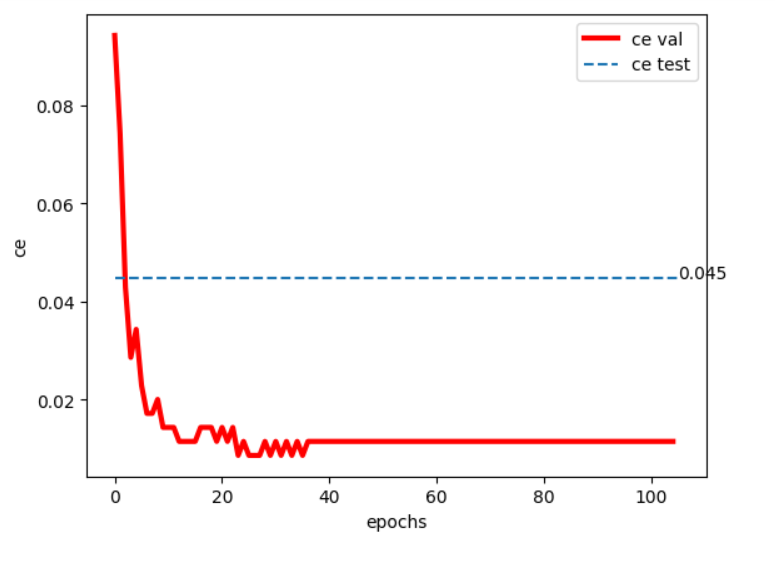






**Question 4 (0-0.5pt)**: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

**Answer**: In general, CNN's perform better at image classiciation because they are better at preserving the spatial structure of an image through convolutional layers. This enables them to capture certain features that are lost in MLP's. Moreover, the number of weights per input layer is lower for CNN's which is more effective for images with input data of higher dimensions.

## 3 Application to Street House View Numbers (SVHN) (6pt)

Please repeat (some) of the code in the previous section and apply a bigger convolutional neural network (CNN) to the following dataset:

http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. (1pt) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. (1pt) Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. (1pt) Provide a good explanation of the applied architecture and a description of all components.
5. (2pt) Analyze the results.

**Please be very precise, comment your code and provide a comprehensive and clear analysis.**

In [51]:
# Load the train and test data
train_data = scipy.io.loadmat('train_32x32.mat')
test_data = scipy.io.loadmat('test_32x32.mat')
# Retrieve the feature matrices
train_X, test_X = train_data['X'], test_data['X']
train_y, test_y = train_data['y'], test_data['y']
train_X.shape, test_X.shape
# train_data



((32, 32, 3, 73257), (32, 32, 3, 26032))

array([[[ 19,  54, 110],
        [ 20,  52, 111],
        [ 25,  57, 116],
        ...,
        [ 65, 144, 223],
        [ 78, 148, 218],
        [ 98, 158, 220]],

       [[ 21,  53, 110],
        [ 19,  52, 106],
        [ 25,  56, 111],
        ...,
        [ 63, 137, 208],
        [ 91, 153, 214],
        [130, 180, 229]],

       [[ 21,  53, 110],
        [ 20,  51, 106],
        [ 22,  52, 106],
        ...,
        [ 79, 147, 210],
        [125, 181, 230],
        [178, 218, 254]],

       ...,

       [[ 88, 162, 237],
        [ 89, 163, 238],
        [ 84, 156, 230],
        ...,
        [ 62, 142, 227],
        [ 67, 144, 226],
        [ 74, 145, 225]],

       [[ 88, 164, 240],
        [ 87, 160, 237],
        [ 88, 159, 237],
        ...,
        [ 60, 141, 230],
        [ 61, 141, 228],
        [ 65, 143, 226]],

       [[ 84, 160, 238],
        [ 81, 154, 233],
        [ 87, 158, 238],
        ...,
        [ 63, 144, 235],
        [ 62, 143, 232],
        [ 63, 145, 231]]], dtype=uint8)
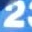

In [52]:
train_X[:,:,:,2]

In [53]:
train_y.shape
train_y[2]

array([2], dtype=uint8)

array([[[ 75,  82,  92],
        [ 74,  81,  91],
        [ 71,  78,  88],
        ...,
        [ 72,  81,  90],
        [ 72,  81,  89],
        [ 72,  81,  88]],

       [[ 73,  80,  91],
        [ 72,  79,  90],
        [ 69,  77,  87],
        ...,
        [ 72,  81,  90],
        [ 73,  82,  89],
        [ 73,  82,  89]],

       [[ 69,  75,  87],
        [ 68,  74,  86],
        [ 66,  74,  85],
        ...,
        [ 72,  82,  91],
        [ 74,  84,  91],
        [ 74,  84,  91]],

       ...,

       [[ 86,  92, 107],
        [ 87,  93, 108],
        [ 90,  95, 110],
        ...,
        [ 76,  80,  91],
        [ 72,  76,  87],
        [ 71,  75,  86]],

       [[ 86,  90, 105],
        [ 86,  91, 105],
        [ 87,  93, 106],
        ...,
        [ 77,  81,  92],
        [ 73,  77,  88],
        [ 72,  76,  86]],

       [[ 86,  89, 104],
        [ 86,  90, 104],
        [ 86,  92, 104],
        ...,
        [ 77,  81,  92],
        [ 74,  78,  88],
        [ 73,  77,  86]]], dtype=uint8)
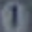

In [54]:
test_X[:,:,:,5]

In [55]:
test_y[5]

array([1], dtype=uint8)

1. **Create a Data Class**

In [56]:
# 1. Create a Data class
class SVHN(Dataset):
    """Street House View Numbers dataset."""

    def __init__(self, dataset:str, sample_size=None, transforms=None):
        self.data = scipy.io.loadmat(dataset)
        self.sample_size = sample_size
        # takes a random sample from the data based on sample_size
        if sample_size is not None:
            self.sample_indices = np.random.choice(self.data['X'].shape[-1], sample_size, replace=False)
        else:
            self.sample_indices = np.arange(self.data['X'].shape[-1])
        self.transform = transforms

    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
         '''
         Params:
           idx: the index of the image or label.
         Returns:
          An image or label
         '''
         # Extract the index of the data
         sample_idx = self.sample_indices[idx]
         # Convert data corresponding to the sample index to float32.
         image = self.data['X'][:, :, :, sample_idx].astype(np.float32)
         # Transpose the image data
         image = np.transpose(image, (2, 0, 1))
         # Extract the label of the dataset
         label = int(self.data['y'][sample_idx]) - 1
         if self.transform is not None:
             image = self.transform(image)
         return image, label

In [57]:
train_X = SVHN('train_32x32.mat', sample_size=1000)
test_svhn = SVHN('test_32x32.mat', sample_size=350)
train_X.__getitem__(2)
len(train_X)
image, label = train_X.__getitem__(0)
image.shape



<ipython-input-56-ff3805a753cd>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.data['y'][sample_idx]) - 1


(3, 32, 32)

In [58]:
# Create a validation set
validation_perc = 0.2  # take 20% of the training data

# Calculate the size of the validation set
length_train = len(train_X)
num_validation = int(validation_perc * length_train)
num_train = length_train - num_validation

# Split the training dataset into training and validation sets
train_svhn, val_svhn = random_split(train_X, [num_train, num_validation])



In [59]:
# batch_size = 128
train_loader_2 = torch.utils.data.DataLoader(train_svhn, batch_size=128, shuffle=True)
val_loader_2 = torch.utils.data.DataLoader(val_svhn, batch_size=128, shuffle=False)
test_loader_2 = torch.utils.data.DataLoader(test_svhn, batch_size=128, shuffle=False)


In [60]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

2. **Implement a CNN architecture**
3. **Add an extra measure to improve the architecture (dropout)**


-> START classifier_cnn


<ipython-input-56-ff3805a753cd>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.data['y'][sample_idx]) - 1


Epoch: 0, val nll=2.396465148925781, val ce=0.865
Epoch: 10, val nll=2.2037776947021483, val ce=0.82
Epoch: 20, val nll=2.052102355957031, val ce=0.74
Epoch: 30, val nll=1.8767225646972656, val ce=0.685
Epoch: 40, val nll=1.779953384399414, val ce=0.63
Epoch: 50, val nll=1.7167762756347655, val ce=0.575
Epoch: 60, val nll=1.7598982238769532, val ce=0.56
Epoch: 70, val nll=1.6885558319091798, val ce=0.525
Epoch: 80, val nll=1.6883343505859374, val ce=0.515
Epoch: 90, val nll=1.7523320770263673, val ce=0.51
-> FINAL PERFORMANCE: nll=1.8699594116210938, ce=0.5257142857142857


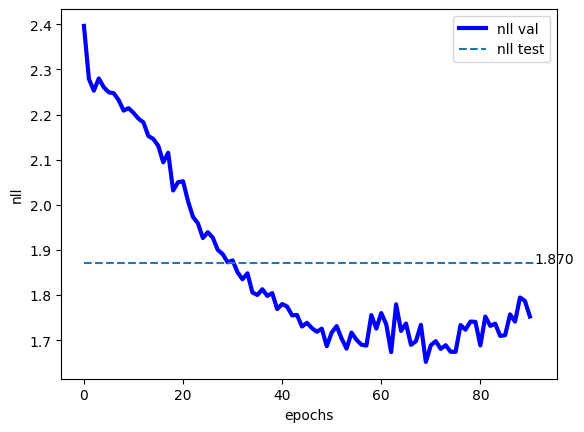

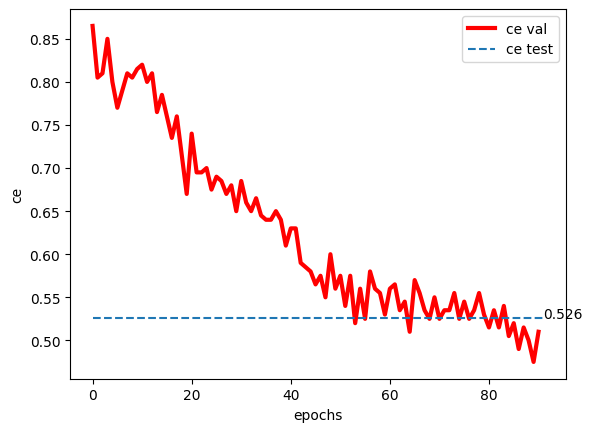

In [70]:
# 2. Implement a CNN architecture
# 3. Add an extra measure to improve the architecture
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ["classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    result_dir = os.path.join(results_dir, "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "./"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)
    if name[0:14] == "classifier_cnn":

        # classnet = nn.Sequential(
        #         # Reshape(size=(3, 32, 32)),          # Reshape input to correct dimensions
        #         nn.Conv2d(in_channels=3, out_channels=num_kernels, kernel_size=3, padding=1),  # Convolutional layer
        #         nn.ReLU(),                          # Activation function
        #         nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer
        #         Flatten(),                          # Flatten the output of convolutional layers
        #         nn.Linear(num_kernels * 16 * 16, M),  # Linear layer
        #         nn.ReLU(),                          # Activation function
        #         nn.Linear(M, K),                    # Output layer
        #         nn.LogSoftmax(dim=1)                # LogSoftmax activation for output
        #     )
        classnet = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=num_kernels, kernel_size=3, padding=1),  # First convolutional layer
            nn.ReLU(),  # Activation function after the first convolution
            nn.Dropout(p=0.5),
            nn.AvgPool2d(kernel_size=2, stride=2),  # average pooling layer after the first convolution
            nn.Conv2d(in_channels=num_kernels, out_channels=512, kernel_size=7),  # Second convolutional layer
            nn.ReLU(),  # Activation function after the second convolution

            Flatten(),  # Flatten the output of convolutional layers

            nn.Linear(512 * 10 * 10, 20),  # First fully connected layer with 20 hidden units
            nn.ReLU(),  # Activation function after the first fully connected layer

            nn.Linear(20, K),  # Second fully connected layer (output layer) with K units
            nn.LogSoftmax(dim=1)  # LogSoftmax activation for output
        )


        # Initialize ClassifierNN
        model = ClassifierNeuralNet(classnet)

        # Initialize OPTIMIZER (here we use ADAMAX)
        optimizer = torch.optim.Adamax(
            [p for p in model.parameters() if p.requires_grad == True],
            lr=lr,
            weight_decay=wd,
        )

        # Print out the shapes of the layers
        # print("Input shape:", model.classnet[0].weight.shape)  # Shape of the input to the first convolutional layer
        # print("Shape after first convolution:", model.classnet[0].weight.shape)  # Shape after the first convolutional layer
        # print("Shape after second convolution:", model.classnet[3].weight.shape)  # Shape after the second convolutional layer
        # print("Shape after flattening:", "To be printed after running the model")  # Placeholder for shape after the Flatten layer
        # print("Shape after first linear layer:", model.classnet[6].weight.shape)  # Shape after the first linear layer




        # Training procedure
        nll_val, error_val = training(
            name=result_dir + name,
            max_patience=max_patience,
            num_epochs=num_epochs,
            model=model,
            optimizer=optimizer,
            training_loader=train_loader_2,
            val_loader=val_loader_2,
        )

        # The final evaluation (on the test set)
        test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader_2)
        # Write the results to a file
        f = open(result_dir + name + "_test_loss.txt", "w")
        f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
        f.close()
        # Create curves
        plot_curve(
            result_dir + name,
            nll_val,
            file_name="_nll_val_curve.pdf",
            ylabel="nll",
            test_eval=test_loss,
        )
        plot_curve(
            result_dir + name,
            error_val,
            file_name="_ca_val_curve.pdf",
            ylabel="ce",
            color="r-",
            test_eval=test_error,
        )

4. **Explanation** <br>
The CNN architectre consists of two convolutional layers with ReLU activations. The first convolutional layer employs 32 filters with a
3x3 kernel size, while the second layer employs 512 filters with a 7x7 kernel size. After the first layer dropout is applied as an extra measure to improve performance and prevent overfitting, followed by avergage pooling. After the flattening the feature maps, the network has two fully connected layers with ReLU activations. The final values are activated by a LogSoftMax function.


5. **Analysis**
Even though the model initially shows consistent improvement in performance during training, with decreasing NLL and Classification error as the epochs progress, the final CE and NLL remain relatively high. This means there is potential room for improvement and need for fine-tuning. The model could also benefit of more training instances and larger batch sizes. Because of memory constraints only a small subset of the total dataset is used for training and testing. Additionally, further hyperparameter tuning such as increasing the number of filters to capture more intricate patterns in the data could be implemented to improve the performance.